<a href="https://colab.research.google.com/github/katty-anay/Fluid_mechanics_/blob/main/Report-Navier-Stokes-ALE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations - ALE**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations using an ALE method, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [ ]:
# This program has been written with a template from
# DD2365 Advanced Computation in Fluid Mechanics,
# KTH Royal Institute of Technology, Stockholm, Sweden.

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This report has been written by Katty Raboanarijaona (20021105-T545)

# **Set up environment**

In [211]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time Arbitrary Lagrangian-Eulerian (ALE) finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + ((u-m)\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term. The mesh velocity is denoted by m.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

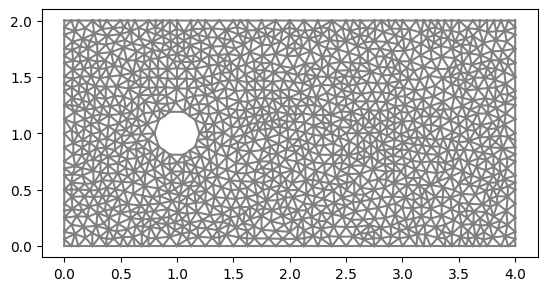

In [212]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [213]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [214]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
bcp1 = DirichletBC(Q, pout, dbc_right)

bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [215]:
# Set viscosity
nu = 4.0e-3

**Define method parameters**

In [216]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Define mesh deformation w, mesh velocity = w/dt
#original problem
amp_x = 0.0
amp_y = 1.0e-2
freq = 0.1

#modification to have deformation without up and down
amp_x = 1.0e-2
amp_y = 0.0
freq = 0.1

#modification to have flapping wing
amp_x = 1.0e-1
amp_y = 1.0e-2
freq = 0.8

t = 0.0
w = Expression(("amp_x*sin(2.0*pi*t*freq)*sin(pi*x[0]/L)","amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*x[1]/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [217]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*(um1-w/dt), v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*(um1-w/dt) + grad(p1), grad(v)*(um1-w/dt))*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*(um1-w/dt) + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In [218]:
# Drag
phi_x = 1.0
phi_y = 0.0

psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

drag = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

# Lift
phi_x = 0.0
phi_y = 1.0

psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

lift = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [219]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 20

# Force computation data
drag_array = np.array(0.0)
drag_array = np.delete(drag_array, 0)
lift_array = np.array(0.0)
lift_array = np.delete(lift_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

In [ ]:
!rm results-NS/*

# Time stepping
T = 30
t = dt

while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    pin.t = t
    #uin.t = t

    w.t = t
    ALE.move(mesh, w)

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        Drag = assemble(drag)
        Lift = assemble(lift)
        if (t > start_sample_time):
          drag_array = np.append(drag_array, normalization*Drag)
          lift_array = np.append(lift_array, normalization*Lift)
          time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plt.figure()
        plot(mesh, title="Mesh")

        plot_time += T/plot_freq

        plt.show()

        plt.figure()
        plt.title("Drag coefficient")
        plt.plot(time, drag_array)
        plt.show()

        plt.figure()
        plt.title("Lift coefficient")
        plt.plot(time, lift_array)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

# **Moving cylinder (up and down)**

For the original settings (f=0.1, amp_x=0.0 and amp_y=1e-2) we obtain the following forces :

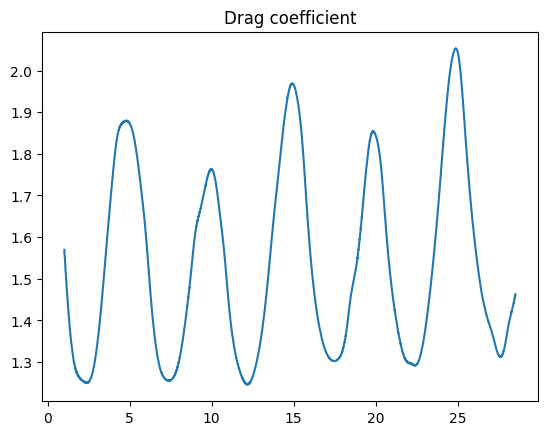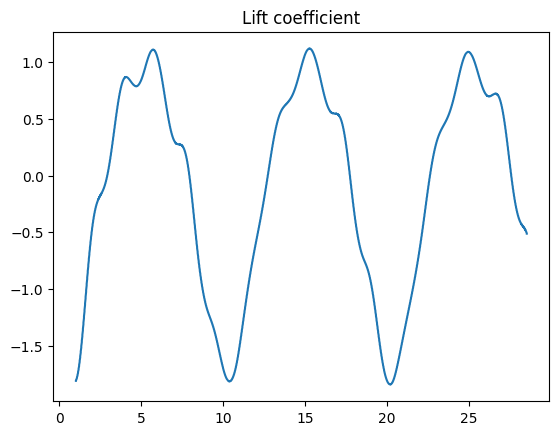

To interpret the plots above we may plot the mesh deformation at two different timesteps :

Time t = 3.022665674238231

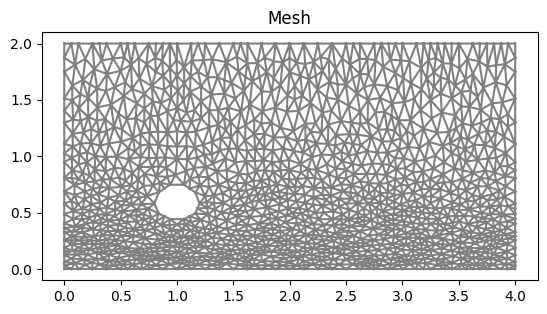

Time t = 7.523809123919094

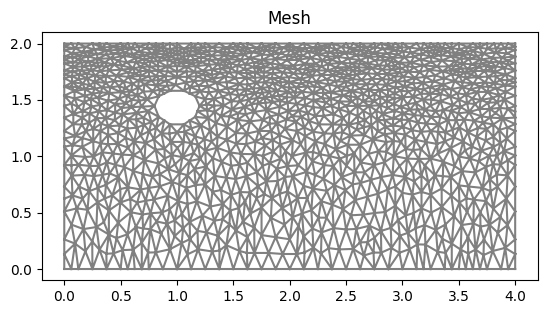

# **Moving cylinder (without up and down)**

For this movement we set (f=0.1, amp_x=1e-2 and amp_y=0.0) we obtain the following forces :

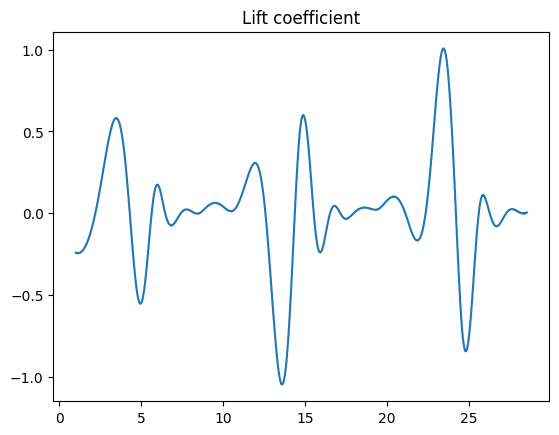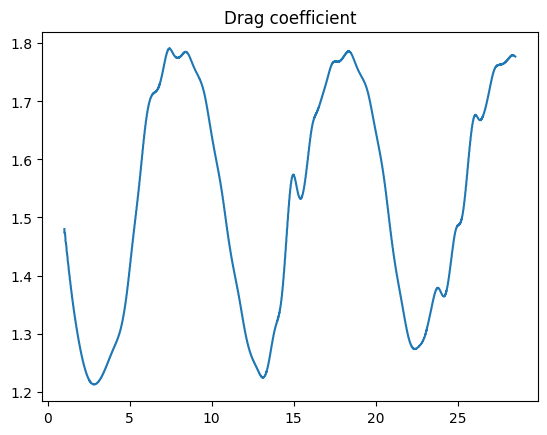


To interpret the plots above we may plot the mesh deformation at different timesteps :

Time t = 13.503430349042427

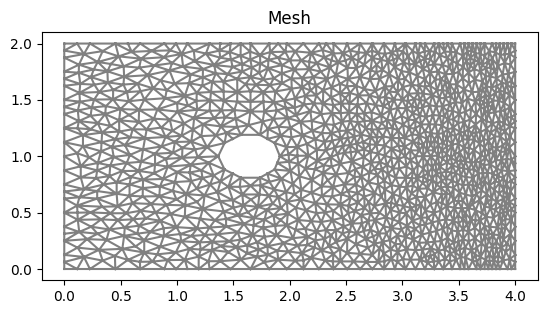

Time t = 22.505717248404263

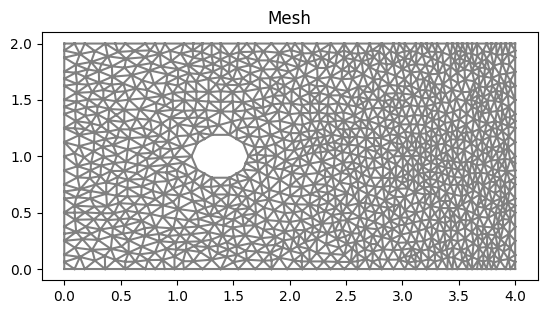

Time t = 28.51819353520441

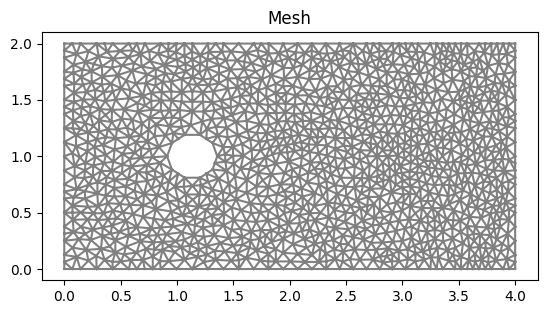

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D using an ALE finite element method.

## With up and down
With the original settings we observe a up and down movement of the cylinder. Thus the mesh deformation is along the vertical axis with compression (in the orientation where the cylinder is going) and "traction" (in the other one).

With the drag coefficient plot we can see that the drag evolves in phase with the movement. Indeed, when the cylinder is going down (T≈3) the drag decreases and tends to its minimal value. Whereas when the cylinder goes back to the upper part of the channel (T≈7) the drag increases.

With the lift, it is different because there is a cyclic pattern but we can not link it directly to the up and down movement.

We may observe that here the frequency is set to f=0.1. For the drag coefficient it corresponds to the frequency with a period containing two peaks (one high and one smaller). For the lift coefficient this corresponds to only one peak.

We also notice that the lift is oscillating around zero and when the zero corresponds to the time step where the cylinder is not deformed.

## Without up and down

When switching the amp_x and amp_y parameters, we have a mesh deformation along the horizontal axis since the cylinder is now going left and right.

The behavior of the drag and lift coefficients changed. Indeed, the lift reaches a maximum value when the cylinder is strongly deformed (horizontally) just before the mesh is compressed on the right-hide side. It also stabilizes around zero when the cylinder is not deformed (between cycles).

The drag reaches minimal/maximal value when the cylinder is close to its original position.

## Flapping wing

We can try to mimic a flapping wing by combining x and y movements.
We export the data to create a video on Paraview (attached to the report).

The will to maximize lift and minimize drag is not easy to achieve thus the following plots might not be optimal.

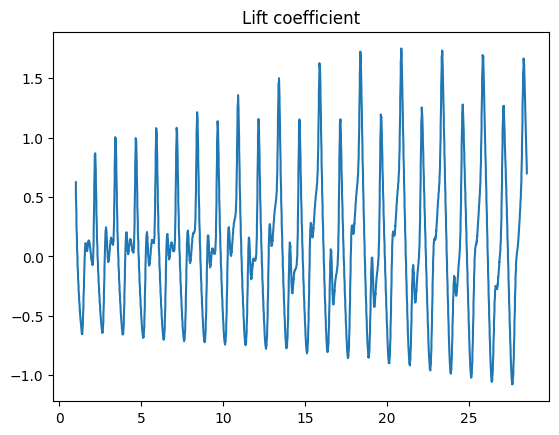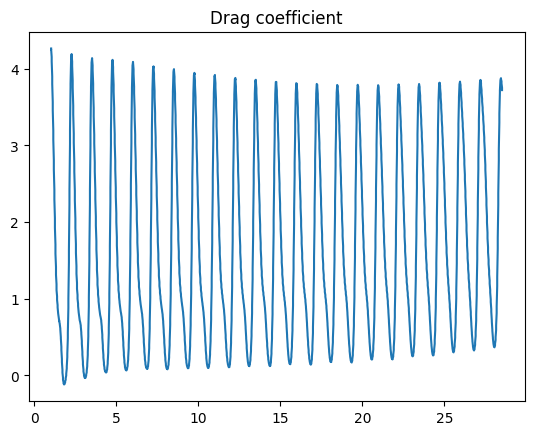